<a href="https://colab.research.google.com/github/ArshiAbolghasemi/AI-UT/blob/main/hidden-markov-models/speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Recognition
In this project, we will develop a speech recognition system for numbers based on **Hidden Markov Models (HMMs)**.
We have a dataset that contains records of 6 different speakers pronouncing numbers 0 to 9 in English.

# Settings And Imports

This section contains libraries and settings that are required.

## Imports

In [71]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import os
from typing import List, Dict, Any
from google.colab import drive

## Settings

In [99]:
DRIVE_MOUNTED_PATH=os.path.join(os.getcwd(), 'drive/')
AUDIOS_DATASET_PATH=os.path.join(DRIVE_MOUNTED_PATH, 'MyDrive/AI-UT/hidden-markov-models/recordings/')

N_MFCC=13
HOP_LENGTH=512

## Mountin to google drive

In [100]:
drive.mount(DRIVE_MOUNTED_PATH)

Mounted at /content/drive/


# Data Preprocessing and Feature Extracting



## Load Audios Dataset
First, let's load our audio data samples.

In [101]:
def load_audios_dataset() -> List[Dict[str, Any]]:
  audios_data = list(dict())
  for audio_file in os.listdir(AUDIOS_DATASET_PATH):
    audio_file_path = os.path.join(AUDIOS_DATASET_PATH, audio_file)
    signal, sr = librosa.load(audio_file_path)
    audios_data.append({
        'signal': signal,
        'sampling_rate': sr,
    })

  return audios_data

audios_data = load_audios_dataset()

## Segmentation

1. Does **segmentation** useful for this dataset? why?
> In the scenario you've described, segmentation would likely be very useful for various tasks such as **feature extraction**, and **noise reduction** and it helps to our **process be more efficient**.
>- **Feature Extraction**: For tasks like speech recognition or speaker identification, feature extraction is crucial. Segmenting the audio into smaller frames allows for the extraction of features such as MFCCs, which capture the spectral characteristics of speech over short time windows. By extracting features from each segment independently, you can capture the nuances of each speaker's pronunciation and speech patterns more effectively.
> - **Noise Reduction**: If the audio recordings contain background noise or interference, segmentation can aid in targeted noise reduction. By segmenting the audio into smaller frames, it becomes easier to identify and remove segments that are corrupted by noise. This improves the overall quality of the audio data and enhances the performance of downstream tasks such as speech recognition.
> - **Efficient Processing**: Processing 3000 audio files containing numerous repetitions of 0 - 9 digits pronounced by six speakers can be computationally intensive. Segmenting the audio into smaller frames allows for more efficient processing, as you can analyze smaller segments in parallel. This reduces computational requirements and facilitates faster processing of the audio data.

## Feature Extraction


### Audio Features Explaination

2. Explain each of the following terms: "MFCC," "Zero Crossing Rate," "mel-spectrogram," and "chroma features," as well as the relationships between them.
> **MFCC (Mel-frequency cepstral coefficients)**:
MFCCs are a widely used feature representation for audio signals, particularly in speech and music processing. They capture the spectral characteristics of audio signals by transforming the frequency domain representation of the signal into a compressed, decorrelated form. MFCCs are obtained by taking the Discrete Cosine Transform (DCT) of the log of the power spectrum of the signal, after mapping the frequency axis to the mel scale, which approximates the human auditory system's response to different frequencies. MFCCs are commonly used as features for tasks such as speech recognition, speaker identification, and music genre classification.<br>
> **Zero Crossing Rate**: The zero crossing rate (ZCR) is a simple feature that measures the rate at which a signal changes its sign (crosses zero) within a given time window.Higher ZCR values indicate more rapid changes in the audio signal, which may correspond to sounds with higher pitch or more rapid variations in amplitude.<br>
> **Mel-spectrogram**: A mel-spectrogram is a spectrogram where the frequency axis is converted from Hertz to the mel scale, which approximates the human auditory system's perception of pitch. A mel-spectrogram represents the time-varying frequency content of an audio signal over time.<br>
> **Chroma Features**: Chroma features represent the distribution of pitch classes (or chroma) in an audio signal, disregarding the exact frequency information. Chroma features are particularly useful for tasks where the harmonic content and tonal structure of the audio signal are important, such as music genre classification, chord recognition, and melody extraction.<br>
> Relationships between the terms:<br>
  - MFCCs, mel-spectrograms, and chroma features are all representations of audio signals commonly used in audio processing tasks.
  - Mel-spectrograms and chroma features are derived from the frequency domain representation of the audio signal, while MFCCs are derived from the mel-scaled power spectrum.
  - MFCCs capture both spectral and temporal characteristics of audio signals and are widely used as features in speech and music processing tasks.
  - Mel-spectrograms provide a perceptually relevant representation of the frequency content of audio signals, while chroma features focus on the tonal content.
  - Zero crossing rate provides information about the temporal dynamics of the audio signal and can be used in conjunction with other features to characterize audio signals further.

### MFCC
Now, let's compute MFCC for each sample

In [102]:
def compute_mfcc(audios_data: List[Dict[str, any]]) -> List[np.ndarray]:
  return list(map(
      lambda audio_data: librosa.feature.mfcc(
          y=audio_data['signal'],
          sr=audio_data['sampling_rate'],
          hop_length=HOP_LENGTH,
          n_mfcc=N_MFCC
      ),
      audios_data
  ))

mfccs = compute_mfcc(audios_data)

Here is a heatmap of the MFCCs for one of our samples.

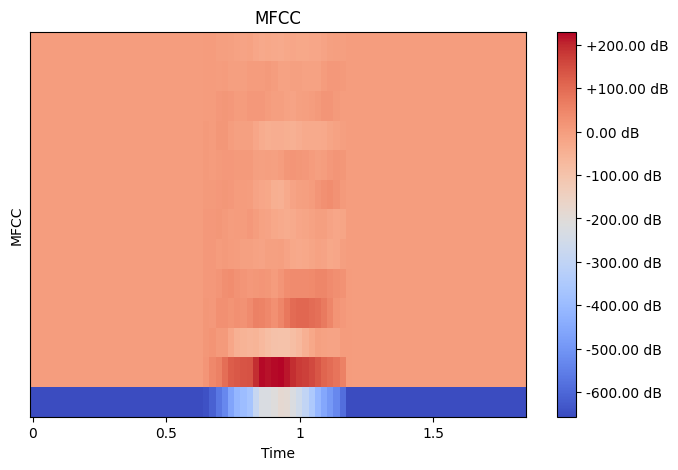

In [109]:
def display_mfcc_heat_map(mfcc: np.ndarray, audio_data: Dict[str, Any]) -> None:
  plt.figure(figsize=(8, 5))
  librosa.display.specshow(mfcc, x_axis='time', sr=audio_data["sampling_rate"])
  plt.colorbar(format=ticker.FuncFormatter(
      lambda x, pos: f'+{x:.2f} dB' if x > 0 else f'{x:.2f} dB'))
  plt.title('MFCC')
  plt.xlabel('Time')
  plt.ylabel('MFCC')
  plt.show()

audio_data_idx = random.randint(0, len(os.listdir(AUDIOS_DATASET_PATH)) - 1)
display_mfcc_heat_map(mfccs[audio_data_idx], audios_data[audio_data_idx])

3. Examining the robustness of MFCCs against changes in signals and noise.
>MFCC is very sensitive to noise interference, which tends to drastically degrade the performance of recognition system

4. Are there any situations where MFCCs are least efficient?
>While Mel-Frequency Cepstral Coefficients (MFCCs) are widely used and generally effective for many audio processing tasks, there are situations where they may be less efficient or less suitable compared to other feature extraction techniques. Some scenarios where MFCCs may be less efficient include:
>- Non-Stationary Signals
>- Highly Dynamic Signals
>- Highly Noisy Environments

5. Why do the coefficients overlap with each other in calculating MFCCs?
>Overlap between adjacent MFCC coefficients helps improve the representation of the spectral characteristics of the audio signal, enhances the discriminative power of the features, and ensures robustness to variations in the signal.

6. Why are only first 12 or 13 MFCC coefficients commonly used in most projects?
> The reason why we typically consider only the first 13 MFCCs is that they capture the most relevant information for speech recognition while discarding redundant information. Higher-order coefficients contain less discriminatory information and are more sensitive to noise, so they are often excluded to reduce computational complexity and improve the performance of speech processing systems.

# Introduction To HMMs

1. What is the meaning of 'state' and 'observation' in HMMs? In this problem, what are our states and how are observations perceived?
>**State** represents the underlying, unobservable (hidden) variables that govern the behavior of the system. Each state is associated with a probability transitions to other states.<br>
>**Observation** represents the observable outcomes or measurements associated with each state, providing information about the underlying state of the system.
Each state is associated with a probability distribution over possible observations.<br>
>In this problem, our states are each digit from 0 to 9, and our observations are features that are extracted from the audio signal. These features provide information about the sound characteristics of the speech signal.

2. HMMs can be categorized based on dependencies between hidden states. Explain First-Order HMM and describe its difference with other types of HMM.
> The First-Order HMM is a type of HMM that state z<sub>t</sub> at time t, depends only on the previous state z<sub>t - 1</sub> at time t-1. The n-th Order HMM depends on n previous states.<br>
> In a First-Order HMM, since we only depend on the previous state, we can calculate the distribution over states as follows:
><center>$$P(z_1, z_2,.., z_N) = P(z_1)\prod_{i=2}^{N}P(z_i|z_{i-1})$$</center>
> There is another assumption that is called Stationary assumption that we can define it as follows: "transition probabilities the same at all times".<br>
> Also past and future are independent given the present.

3. For which kind of problems is HMM more suitable?
> HMMs are sutiable for problems that we want reasoning about a sequence of observations events and events that we are interested in are hidden. HMMs allows us to talk about both observed events Hidden and hidden events that
we think of as causal factors in our probabilistic mode.<br>
>Here are some types of problems where HMMs are commonly used:
>- Speech Recognition
>- Robot Localization
>- User Attention
>- Medical Monitoring

4. Describe pros and cons of HMM.
> pros:
><ul>
    <li>
      <b>Efficiency and Scalablity</b>: thanks to the Markov property that reduces the computational complexity of inference and learning. Algorithms such as the forward-backward algorithm, the Viterbi algorithm, or the Baum-Welch algorithm can be used to further optimize performance.
    </li>
    <li>
      <b>Simplicity</b>: HMMs are relatively simple to understand and implement compared to other models.
    </li>
    <li>
      <b>Robustness</b>: HMMs are robust to noise and uncertainty, which is particularly useful in speech recognition where the quality of audio recordings can be poor.
    </li>
    <li>
      <b>Flexibility and Expressiveness</b>: enables them to model complex and non-linear dependencies between hidden states and observations.
    </li>
></ul>
>cons:
><ul>
    <li>
      They are restrictive and simplistic, as they assume that the hidden states are discrete and finite, and that the observations are conditionally independent given the hidden states, which may not be true
    </li>
    <li>
      They are prone to overfitting and underfitting due to needing a careful choice of the number of hidden states and prior distributions over the parameters
    </li>
    <li>
      They are sensitive and brittle, as they rely on quality and quantity of observed data, and may suffer from data sparsity, noise, or missing values.
    </li>
></ul>

5. Explain other types of HMMs.

>HMMs can be classified according to the nature of the distribution of the output probabilities $b_i(O_k)$
. If the observations $O_k$ are discrete quantities, as we have assumed up until now, then $b_i(O_k)$ are probability mass functions (PMFs), and the HMM is called a discrete HMM. If the observations are continuous random variables, then the HMM is called a continuous HMM. In this case, $b_i(O_k)$ are probability distribution functions (PDFs) and we have a continuous observation space.

>- **First-Order HMM**: The state transitions depend only on the current state and not on previous states. This is the simplest form of HMM.
>- **Higher-Order HMM**: In contrast to a first-order HMM, higher-order HMMs allow transitions to depend on multiple previous states. These models can capture more complex dependencies in sequential data but may require more parameters and computational resources.
>- **Left-Right HMM**: A left-to-right HMM has a left-to-right transition to the next state as well as a self-transition. The self-transition is used to model contiguous features in the same state. It is popularly used to model speech as a time sequence of distinct events that start at an initial state, which is usually labeled Begin, and end at a final state, which is usually labeled End
>- **Hidden Semi-Markov Model (HSMM)**: A hidden semi-Markov model (HSMM) is a statistical model with the same structure as a hidden Markov model except that the unobservable process is semi-Markov rather than Markov. This means that the probability of there being a change in the hidden state depends on the amount of time that has elapsed since entry into the current state. This is in contrast to hidden Markov models where there is a constant probability of changing state given survival in the state up to that time.
>- **Factorial HMM**: A Factorial Hidden Markov Model (FHMM) is a type of probabilistic model that extends the traditional Hidden Markov Model (HMM) to handle multiple observation sequences simultaneously. In an FHMM, each observation sequence is associated with its own set of hidden states, but the hidden states from different sequences are interconnected through shared parameters. This allows the model to capture dependencies between multiple sequences and perform joint inference across them.
>- **Profile HMM**: A Profile Hidden Markov Model (Profile HMM) is a probabilistic model commonly used in bioinformatics for sequence analysis tasks such as sequence alignment and protein family classification. Profile HMMs are derived from multiple sequence alignments (MSAs) of related sequences and are designed to capture the evolutionary relationships and sequence conservation within a protein family or a set of related sequences.



